In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [20]:

%cd /content/gdrive/My\ Drive/Tesis_Resources/YOLO_TransferLearning_Ultralytics/yolov3/data
!pwd
!rm -rf samples  # delete output folder
!ls
!mkdir samples

/content/gdrive/My Drive/Tesis_Resources/YOLO_TransferLearning_Ultralytics/yolov3/data
/content/gdrive/My Drive/Tesis_Resources/YOLO_TransferLearning_Ultralytics/yolov3/data
5k.shapes	   coco_1cls.txt     coco_64img.txt
5k.txt		   coco_1img.data    coco.data
Clase02.mp4	   coco_1img.txt     coco.names
coco_1000img.data  coco_1k5k.data    coco_paper.names
coco_1000img.txt   coco_32img.data   get_coco_dataset_gdrive.sh
coco_1000val.data  coco_32img.txt    get_coco_dataset.sh
coco_1000val.txt   coco_500img.txt   trainvalno5k.shapes
coco_16img.data    coco_500val.data  Video2.mp4
coco_16img.txt	   coco_500val.txt   Video3.mp4
coco_1cls.data	   coco_64img.data   Video.mp4


In [13]:
!cp /content/gdrive/My\ Drive/Tesis_Resources/corpus/Video3.mp4 . #Video.mp4 .
import cv2
import argparse
from sys import platform

vidcap = cv2.VideoCapture('Video3.mp4') # Video.mp4

success,image = vidcap.read()
count = 0

while success:
  cv2.imwrite("/content/gdrive/My Drive/Tesis_Resources/YOLO_TransferLearning_Ultralytics/yolov3/data/samples/frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  count += 1

frames = vidcap.get(cv2.CAP_PROP_POS_FRAMES)
segundos = vidcap.get(cv2.CAP_PROP_POS_MSEC) / 1000
frames_segundos = round(frames/segundos)

print(frames)
print(segundos)
print(frames_segundos)


%cd /content/gdrive/My\ Drive/Tesis_Resources/YOLO_TransferLearning_Ultralytics
#!git clone https://github.com/ultralytics/yolov3

862.0
35.95258333333333
24
/content/gdrive/My Drive/Tesis_Resources/YOLO_TransferLearning_Ultralytics


In [0]:
#!bash yolov3/data/get_coco_dataset_gdrive.sh

In [14]:
%cd yolov3
!ls

/content/gdrive/My Drive/Tesis_Resources/YOLO_TransferLearning_Ultralytics/yolov3
cfg	   Dockerfile	   LICENSE    __pycache__	test.py   Video.mp4
data	   examples.ipynb  models.py  README.md		train.py  weights
detect.py  frame0-det.jpg  output     requirements.txt	utils


In [0]:
#!python3 detect.py
#Image(filename='output/frame0.jpg', width=600)

Using CUDA device0 _CudaDeviceProperties(name='Tesla K80', total_memory=11441MB)

image 1/862 data/samples/frame0.jpg: 
image 2/862 data/samples/frame1.jpg: 
image 3/862 data/samples/frame10.jpg: 
image 4/862 data/samples/frame100.jpg: 
image 5/862 data/samples/frame101.jpg: 
image 6/862 data/samples/frame102.jpg: 
image 7/862 data/samples/frame103.jpg: 
image 8/862 data/samples/frame104.jpg: 
image 9/862 data/samples/frame105.jpg: 
image 10/862 data/samples/frame106.jpg: 
image 11/862 data/samples/frame107.jpg: 
image 12/862 data/samples/frame108.jpg: 
image 13/862 data/samples/frame109.jpg: 
image 14/862 data/samples/frame11.jpg: 
image 15/862 data/samples/frame110.jpg: 
image 16/862 data/samples/frame111.jpg: 
image 17/862 data/samples/frame112.jpg: 
image 18/862 data/samples/frame113.jpg: 
image 19/862 data/samples/frame114.jpg: 
image 20/862 data/samples/frame115.jpg: 
image 21/862 data/samples/frame116.jpg: 
image 22/862 data/samples/frame117.jpg: 
image 23/862 data/samples/frame

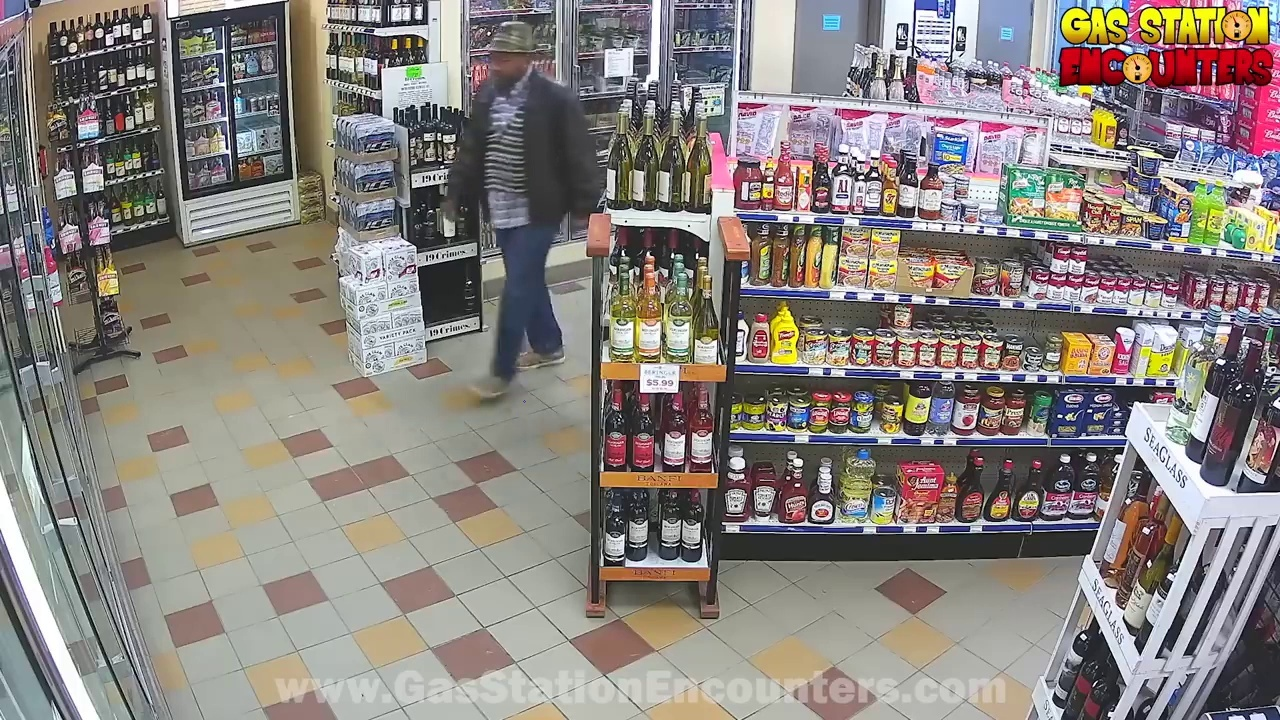

In [15]:
import argparse
from sys import platform

from models import *  # set ONNX_EXPORT in models.py
from utils.datasets import *
from utils.utils import *
from IPython.display import Image, clear_output 
import cv2

list_detections = []

def detect(save_txt=True, save_img=False, stream_img=False):
    img_size = (320, 192) if ONNX_EXPORT else opt.img_size  # (320, 192) or (416, 256) or (608, 352) for (height, width)
    out, source, weights, half = opt.output, opt.source, opt.weights, opt.half
    webcam = source == '0' or source.startswith('rtsp') or source.startswith('http')
    streams = 'streams' in source and source.endswith('.txt')

    # Initialize
    device = torch_utils.select_device(device='cpu' if ONNX_EXPORT else opt.device)
    if os.path.exists(out):
        shutil.rmtree(out)  # delete output folder
    os.makedirs(out)  # make new output folder

    # Initialize model
    model = Darknet(opt.cfg, img_size)

    # Load weights
    if weights.endswith('.pt'):  # pytorch format
        model.load_state_dict(torch.load(weights, map_location=device)['model'])
    else:  # darknet format
        _ = load_darknet_weights(model, weights)

    # Fuse Conv2d + BatchNorm2d layers
    # model.fuse()

    # Eval mode
    model.to(device).eval()

    # Export mode
    if ONNX_EXPORT:
        img = torch.zeros((1, 3) + img_size)  # (1, 3, 320, 192)
        torch.onnx.export(model, img, 'weights/export.onnx', verbose=True)
        return

    # Half precision
    half = half and device.type != 'cpu'  # half precision only supported on CUDA
    if half:
        model.half()

    # Set Dataloader
    vid_path, vid_writer = None, None
    if streams:
        stream_img = False
        torch.backends.cudnn.benchmark = True  # set True to speed up constant image size inference
        dataset = LoadStreams(source, img_size=img_size, half=half)
    elif webcam:
        stream_img = True
        dataset = LoadWebcam(source, img_size=img_size, half=half)
    else:
        save_img = True
        dataset = LoadImages(source, img_size=img_size, half=half)

    # Get classes and colors
    classes = load_classes(parse_data_cfg(opt.data)['names'])
    colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(classes))]

    # Run inference
    t0 = time.time()
    for path, img, im0s, vid_cap in dataset:
        t = time.time()

        # Get detections
        img = torch.from_numpy(img).to(device)
        if img.ndimension() == 3:
            img = img.unsqueeze(0)
        pred, _ = model(img)

        for i, det in enumerate(non_max_suppression(pred, opt.conf_thres, opt.nms_thres)):  # detections per image
            if streams:  # batch_size > 1
                p, s, im0 = path[i], '%g: ' % i, im0s[i]
            else:
                p, s, im0 = path, '', im0s

            save_path = str(Path(out) / Path(p).name)
            s += '%gx%g ' % img.shape[2:]  # print string
            if det is not None and len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += '%g %ss, ' % (n, classes[int(c)])  # add to string
                # Write results
                for *xyxy, conf, _, cls in det:
                  if cls.item() == 0: # Si es de la clase Persona
                    if save_txt:  # Write to file
                        with open(save_path + '.txt', 'a') as file:
                            file.write(('%g ' * 6 + '\n') % (*xyxy, cls, conf))
                            salida = ('%g ' * 6 + '\n') % (*xyxy, cls, conf)
                            print('')
                            #print('salida = ', salida)
                            list_detections.append((int(xyxy[0]) + int((int(xyxy[2]) - int(xyxy[0]))/2), int(xyxy[3])))
                    if save_img or stream_img:  # Add bbox to image
                        label = '%s %.2f' % (classes[int(cls)], conf)
                        #plot_one_box(xyxy, im0, label=label, color=colors[int(cls)])
                        #cv2.circle(im0, (int(xyxy[0]), int(xyxy[1])),5,color=colors[int(cls)]);
                        #cv2.circle(im0, (int(xyxy[2]), int(xyxy[3])),5,color=colors[int(cls)]);
                        x =  int(xyxy[0]) + int((int(xyxy[2]) - int(xyxy[0]))/2)
                        cv2.circle(im0, (x, int(xyxy[3])),1,color=colors[int(cls)]);
            #print('%sDone. (%.3fs)' % (s, time.time() - t))

            # Stream results
            if stream_img:
                cv2.imshow(p, im0)

            # Save results (image with detections)
            if save_img:
                if dataset.mode == 'images':
                    cv2.imwrite(save_path, im0)
                else:
                    if vid_path != save_path:  # new video
                        vid_path = save_path
                        if isinstance(vid_writer, cv2.VideoWriter):
                            vid_writer.release()  # release previous video writer

                        fps = vid_cap.get(cv2.CAP_PROP_FPS)
                        w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                        h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                        vid_writer = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*opt.fourcc), fps, (w, h))
                    vid_writer.write(im0)

    if save_txt or save_img:
        #print('Results saved to %s' % os.getcwd() + os.sep + out)
        if platform == 'darwin':  # MacOS
            os.system('open ' + out + ' ' + save_path)

    #print('Done. (%.3fs)' % (time.time() - t0))


class Opt(object):
  cfg ='cfg/yolov3-spp.cfg'
  data ='data/coco.data'
  weights ='weights/yolov3-spp.weights'
  source ='data/samples'
  output ='output'
  img_size =416
  conf_thres =0.3
  nms_thres =0.5
  fourcc ='mp4v'
  half = ''
  device = ''

opt = Opt()
with torch.no_grad():
  detect()

Image(filename='output/frame10.jpg', width=600)


In [16]:
image = cv2.imread("/content/gdrive/My Drive/Tesis_Resources/YOLO_TransferLearning_Ultralytics/yolov3/data/samples/frame0.jpg")
for x, y in list_detections:
  cv2.circle(image, (x, y),1,color= (0, 0, 255));
cv2.imwrite('/content/gdrive/My Drive/Tesis_Resources/YOLO_TransferLearning_Ultralytics/yolov3/data/samples/frame0.jpg', image)

True

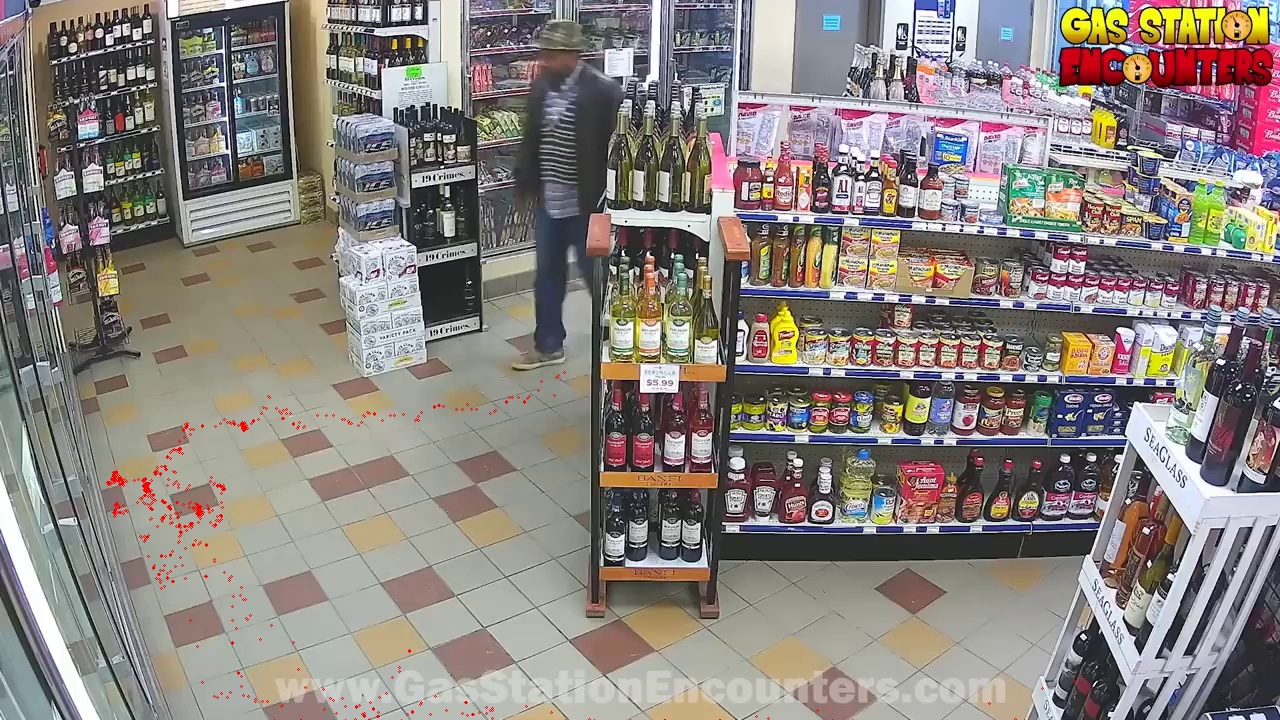

In [17]:
Image(filename='/content/gdrive/My Drive/Tesis_Resources/YOLO_TransferLearning_Ultralytics/yolov3/data/samples/frame0.jpg', width=600)

[(564, 372), (558, 375), (524, 401), (243, 427), (242, 428), (242, 427), (242, 427), (243, 428), (243, 426), (242, 426), (243, 426), (242, 427), (242, 427), (524, 402), (243, 427), (244, 426), (243, 425), (244, 426), (243, 425), (243, 426), (242, 427), (243, 426), (243, 425), (243, 426), (518, 397), (243, 425), (243, 425), (242, 424), (243, 425), (244, 426), (243, 427), (243, 426), (243, 426), (243, 425), (242, 423), (512, 397), (242, 423), (242, 423), (242, 422), (242, 422), (242, 423), (242, 423), (242, 423), (242, 423), (242, 424), (242, 424), (509, 397), (243, 424), (243, 424), (243, 424), (243, 424), (243, 424), (242, 424), (243, 424), (242, 423), (242, 423), (243, 424), (506, 401), (243, 424), (243, 424), (242, 424), (243, 424), (243, 428), (243, 428), (243, 427), (243, 428), (243, 429), (243, 428), (506, 402), (242, 427), (242, 427), (243, 427), (242, 427), (242, 426), (242, 425), (242, 425), (241, 424), (241, 424), (241, 423), (495, 410), (241, 424), (241, 424), (242, 424), (24

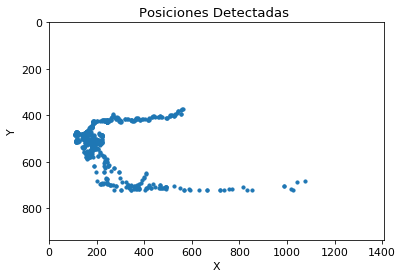

In [18]:
def draw_multiple_points():

    # Draw point based on above x, y axis values.
    plt.scatter(list_x, list_y, s=10)

    # Set chart title.
    plt.title("Posiciones Detectadas ")

    # Set x, y label text.
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.xlim(0, 1280 * 1.1)
    plt.ylim(0, 720 * 1.3)
    ax=plt.gca() 
    ax.invert_yaxis()
    plt.show()

print(list_detections)
list_x = []
list_y = []
for x, y in list_detections:
  list_x.append(x)
  list_y.append(y)

draw_multiple_points()


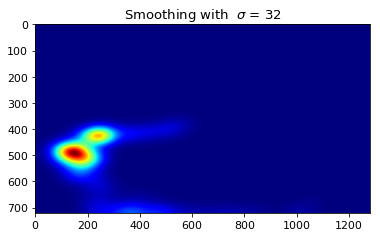

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter


def myplot(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins, range=[[0, 1280], [0, 720]])
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

fig, axs = plt.subplots(1, 1)
# Generate some test data
x = list_x
y = list_y

s = 32 # sigmas = [0]
ax = plt.gca()
#for ax, s in zip(axs.flatten(), sigmas):
plt.xlim(0, 1280)
plt.ylim(0, 720)
if s == 0:
    ax.plot(x, y, 'k.', markersize=5)
    ax.set_title("Scatter plot")
    ax.invert_yaxis()
else:
    img, extent = myplot(x, y, s)
    ax.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
    ax.set_title("Smoothing with  $\sigma$ = %d" % s)
    ax.invert_yaxis()

plt.show()